In [ ]:
import time
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("max_colwidth", 100)
import seaborn as sns
import xgboost as xgb
nb_start = time.time()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SPR\ LA4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1VFnGQED83rJ8QKsM3t6dy57VBaj8i6Gk/SPR LA4


In [ ]:
def generate_data(dims, n_train, n_test, prior0, mu0, mu1, covmat0, covmat1, transform=False, degree=2):
    n_train0 = int(n_train * prior0)
    n_train1 = int(n_train * (1-prior0))

    n_test0 = int(n_test * prior0)
    n_test1 = int(n_test * (1-prior0))

    X_train0 = np.random.multivariate_normal(mu0, covmat0, n_train0)
    X_train1 = np.random.multivariate_normal(mu1, covmat1, n_train1)

    X_train = np.concatenate((X_train0, X_train1), axis=0)
    y_train = np.concatenate((np.zeros(n_train0, ), np.ones(n_train1,))).astype(int)

    X_test0 = np.random.multivariate_normal(mu0, covmat0, n_test0)
    X_test1 = np.random.multivariate_normal(mu1, covmat1, n_test1)

    X_test = np.concatenate((X_test0, X_test1), axis=0)
    y_test = np.concatenate((np.zeros(n_test0, ), np.ones(n_test1,))).astype(int)
    
    if not transform:
        return X_train, y_train, X_test, y_test
    else:
        return transform_data(X_train, y_train, X_test, y_test, degree=degree)

def transform_data(X_train, y_train, X_test, y_test, degree=2, retnfeatures=False):
    poly = PolynomialFeatures(degree)
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    if not retnfeatures:
        return X_train_new, y_train, X_test_new, y_test
    else:
        return X_train_new, y_train, X_test_new, y_test, retnfeatures

def normalize(X_train, y_train, X_test, y_test):
    xmin, xmax = X_train.min(axis=0, keepdims=True), X_train.max(axis=0, keepdims=True)
    X_train = (X_train - xmin) / (xmax - xmin + 1e-8)
    X_test  = (X_test  - xmin) / (xmax - xmin + 1e-8)
    return X_train, y_train, X_test, y_test

In [ ]:
def bayes_q1c(p0, sig0, sig1):
    """
        Returns coeff for bayes boundary
        1, x1, x2, x1**2, x1*x2, x2**2
    """
    assert sig0.shape == sig1.shape, 'sig1 andsig0 must be 2 cross 2'
    assert sig0.shape == (2, 2), 'sig1 andsig0 must be 2 cross 2'
    p1 = 1-p0
    b = np.log(p1/p0) - 0.5* np.log(np.linalg.det(sig1)/np.linalg.det(sig0))
    Q = -0.5 * (np.linalg.inv(sig1)- np.linalg.inv(sig0))
    W = [b, 0, 0, Q[0,0], Q[0,1]+Q[1,0], Q[1,1]]
    return W

sig0 = np.array([[1, .0], [.0, 1]])
sig1 = np.array([[1, .9], [.9, 1]])
b, *_, p, r, q = np.array(bayes_q1c(.5, sig0, sig1)).round(2)
print(f"{p}x_1**2 + {q}*x_2**2 + {r}*x1*x2 + {b} > 0 means class 1")


def bayes_q1a(p0, dim=2):
    """
        Returns coeff for bayes boundary
        x1, x2,... xd, bias
    """
    b = -dim/2 + np.log((1-p0)/p0)
    return [1] * dim + [b]

s, t, b = bayes_q1a(p0=.5, dim=2)
print(f"x1 + x2 + {b} > 0 means class 1")

-2.13x_1**2 + -2.13*x_2**2 + 4.74*x1*x2 + 0.83 > 0 means class 1
x1 + x2 + -1.0 > 0 means class 1


In [ ]:
data = generate_data(10, 2000, 1000, 0.5, np.zeros((10,)), np.ones((10,)) , np.eye(10), np.eye(10))
X_train, y_train, X_test, y_test = normalize(*data)

In [ ]:
class Pocket:
    name = 'POCKET'
    def fit(X_train, y_train, iterations=1000, lr=0.1):
        m, dims = X_train.shape[0], X_train.shape[1]
        
        X_train = np.concatenate((np.ones((m, 1)), X_train), axis=-1)

        X_train, y_train = shuffle(X_train, y_train, random_state=32)
        W_pocket = np.random.normal(0, 0.5, (dims+1,))

        i=0
        prod = X_train @ W_pocket
        mask = ((prod >= 0) & (y_train == 0)) | ((prod < 0) & (y_train == 1))
        mispreds = X_train[((prod >= 0) & (y_train == 0)) | ((prod < 0) & (y_train == 1))]
        min_misp = len(mispreds)

        W_t = W_pocket.copy()

        while i < iterations and min_misp != 0:

            selected = np.random.randint(0, mispreds.shape[0])
            X_t, y_t = mispreds[selected], y_train[selected]
            
            if W_t.T @ X_t >= 0 and y_t == 0:
                W_t = W_t - lr * X_t
            elif W_t.T @ X_t < 0 and y_t == 1:
                W_t = W_t + lr * X_t

            prod = X_train @ W_t
            mask = ((prod >= 0) & (y_train == 0)) | ((prod < 0) & (y_train == 1))
            mispreds = X_train[mask]
            num_mispreds = len(mispreds)

            if min_misp > num_mispreds:
                min_misp = num_mispreds
                W_pocket = W_t.copy()

            i += 1

        return W_pocket[1:], W_pocket[0]

    def predict(X_test, y_test, W, W_0):
        vals = X_test @ W + W_0
        preds = (vals > 0).astype(int)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy

    def sk_predict(X_train, y_train, X_test, y_test):
        clf = Perceptron(tol=1e-3, random_state=0)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy, clf.coef_, clf.intercept_

In [ ]:
class LeastSquares:
    name = 'LeastSquares'
    def fit(X_train, y_train):
        m, dims = X_train.shape[0], X_train.shape[1]
        
        X_train_aug = np.concatenate((np.ones((m, 1)), X_train), axis=-1)

        W = np.linalg.pinv(X_train_aug) @ y_train

        X_train0 = X_train_aug[y_train == 0]
        y_train0 = y_train[y_train == 0]

        X_train1 = X_train_aug[y_train == 1]
        y_train1 = y_train[y_train == 1]

        mu0, mu1 = np.mean(X_train0, axis=0) , np.mean(X_train1, axis=0)

        thresh_array = np.linspace(W.T @ mu0, W.T @ mu1, 100)
        acc_array = [LeastSquares.predict(X_train, y_train, W[1:], W[0], thresh)[1] for thresh in thresh_array]
        thresh = thresh_array[np.argmax(acc_array)]

        return W[1:], W[0], thresh

    def predict(X_test, y_test, W, W_0, thresh=0.5):
        vals = X_test @ W + W_0
        preds = (vals > thresh).astype(int)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy

    def sk_predict(X_train, y_train, X_test, y_test, thresh=0.5):
        clf = LinearRegression()
        clf.fit(X_train, y_train)
        preds = (clf.predict(X_test) > thresh).astype(int)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy, clf.coef_, clf.intercept_

In [ ]:
class LogReg:
    name = "LogisticRegression"
    lr = 1
    class_weights = np.array([1, 1])
    def set_class_weights(pos):
        LogReg.class_weights[0] = .5 / pos
        LogReg.class_weights[1] = .5 / (1 - pos)

    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    def fit(X_train, y_train, iterations=2000):
        # LogReg.set_class_weights(y_train.mean())
        m, dims = X_train.shape[0], X_train.shape[1]
        X_train = np.concatenate((np.ones((m, 1)), X_train), axis=-1)

        W = np.random.normal(0, 1e-4, (dims+1,))

        loss_w = LogReg.class_weights[y_train.astype(int)]
        for i in range(iterations):
            W = W - (1/m) * LogReg.lr * X_train.T @ ((LogReg.sigmoid(X_train @ W) - y_train) * loss_w)

        return W[1:], W[0]

    def predict(X_test, y_test, W, W_0, thresh=0.5):
        vals = LogReg.sigmoid(X_test @ W + W_0)
        preds = (vals > thresh).astype(int)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy

    def sk_predict(X_train, y_train, X_test, y_test):
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy, clf.coef_, clf.intercept_

In [ ]:
class FisherLDA:
    name = 'FisherLDA'
    def fit(X_train, y_train):
        X_train0 = X_train[y_train == 0]
        y_train0 = y_train[y_train == 0]

        X_train1 = X_train[y_train == 1]
        y_train1 = y_train[y_train == 1]

        mu0, mu1 = np.mean(X_train0, axis=0) , np.mean(X_train1, axis=0)
        p1 = y_train.mean()
        S_w = (1-p1)*np.cov(X_train0, rowvar=False) + p1*np.cov(X_train1, rowvar=False)

        W = np.linalg.pinv(S_w) @ (mu1 - mu0)


        b_start, b_end = -W.T.dot(mu1), -W.T.dot(mu0)
        if b_start == b_end:
            b_start -= 1
            b_end += 1
            
        b_samples = 1.5*np.linspace(b_start, b_end, num=1000, endpoint=True)
        acc_arr = np.array([
            FisherLDA.predict(X_train, y_train, W, _b)[1]
            for _b in b_samples
         ])

        b = b_samples[acc_arr.argmax()]


        return W, b

    def predict(X_test, y_test, W, b):
        vals = X_test @ W + b 
        preds = (vals > 0).astype(int)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy

    def sk_predict(X_train, y_train, X_test, y_test):
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        accuracy = np.mean(preds == y_test)
        return preds, accuracy, clf.coef_, clf.intercept_

In [ ]:
def plot_decision_boundary(ax, X_test, y_test, bb, W, *b):
    X_test0 = X_test[y_test == 0]
    X_test1 = X_test[y_test == 1]

    ax.scatter(X_test0[:,0], X_test0[:,1], alpha=0.2, label='neg')
    ax.scatter(X_test1[:,0], X_test1[:,1], alpha=0.2, label='pos')

    W_0 = b[0]

    if len(b) == 2:
        W_0 -= b[1]

    xes = np.linspace(-4, 6, 100)
    yes = -(1/W[1])*(W[0]*xes + W_0)
    ax.plot(xes, yes, color='black', label='ours')

    if bb is not None:# bayes boundary
        yes = - ( bb[2] + bb[0] * xes) / bb[1]
        ax.plot(xes, yes, color='orange', label='bayes')
    ax.legend()

def stats_and_plot(dims, data, bb=None, plot=True):
    for model in [Pocket, LeastSquares, LogReg, FisherLDA]:
        frame = pd.DataFrame({
            'prior': [], 'train_acc':[], 'acc': [], 'sk_acc': [], 'train_f1':[], 'f1': [], 'sk_f1': [], 'weights': [], 'sk_weights': []
        })
        if plot:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'{model.name} algorithm')
        for i, prior in enumerate(data):
            X_train, y_train, X_test, y_test = data[prior]
            W, *b = model.fit(X_train, y_train)
            if plot:
                if bb is not None:
                    plot_decision_boundary(ax[i], X_test, y_test, bb.weights[i], W, *b)
                else:
                    plot_decision_boundary(ax[i], X_test, y_test, None, W, *b)
                ax[i].set_title(f'Prior={prior}')

            tr_preds, tr_acc = model.predict(X_train, y_train, W, *b)
            preds, acc = model.predict(X_test, y_test, W, *b)
            preds_sk, accuracy_sk, skW, skB = model.sk_predict(X_train, y_train, X_test, y_test)
            if type(skB) == np.ndarray:
                skB = skB[0]
            frame = frame.append({
                'prior' : prior,
                'train_acc': tr_acc,
                'acc'   : acc,
                'sk_acc': accuracy_sk,
                'train_f1': f1_score(y_train, tr_preds),
                'f1'    : f1_score(y_test, preds),
                'sk_f1' : f1_score(y_test, preds_sk),
                'weights': list(W.round(2)) + [round(b[0], 2)],
                'sk_weights': list(skW.flatten().round(2)) +[round(skB, 2)]
            }, ignore_index=True)

        frame = frame.round(3).set_index('prior')
        print(f"{model.name} algorithm")
        display(frame)
        print('\n')

## Performance on 10D Data

In [ ]:
# show bayes boundary
dims = 10
priors = [.05, .3, .5]

np.random.seed(0)
data = {
    prior: generate_data(dims, 2000, 1000, prior, np.zeros((dims,)), np.ones((dims,)), np.eye(dims), np.eye(dims))
    for prior in priors
}

bb = pd.DataFrame({})
for p0 in [.05, .3, .5]:
    w = np.array(bayes_q1a(p0, dims))
    X_train, y_train, X_test, y_test = data[p0]
    y_hat = (X_test.dot(w[:-1]) + w[-1]) > 0
    
    bb = bb.append({'prior': p0,
                    'bayes_acc'  : (y_test == y_hat).mean(),
                    'bayes_f1'   : f1_score(y_test, y_hat),
                    'weights': w.round(2)}, ignore_index=True)

print("Bayes Decision Boundary")
display(bb.set_index('prior'))
print('\n')

stats_and_plot(dims, data, bb, plot=False)

Bayes Decision Boundary


,bayes_acc,bayes_f1,weights
prior,,,
0.05,0.980,0.989507,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.06]"
0.30,0.956,0.968616,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -4.15]"
0.50,0.959,0.959526,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -5.0]"




POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.980,0.971,0.955,0.990,0.985,0.976,"[0.71, 0.35, 0.39, 0.8, 0.53, 0.27, 0.05, 0.35, 0.12, 0.12, 0.06]","[5.49, 5.09, 3.81, 3.31, 3.54, 1.02, 5.38, 1.37, 2.8, 0.51, -11.0]"
0.30,0.941,0.950,0.923,0.959,0.965,0.945,"[0.4, 0.4, 0.29, 0.51, 0.59, 0.38, 0.35, 0.39, 0.19, 0.37, -1.24]","[3.22, 4.58, -0.28, 7.3, 5.27, 2.59, 2.05, 3.88, 4.65, 1.0, -15.0]"
0.50,0.953,0.946,0.939,0.953,0.947,0.941,"[0.57, 0.22, 0.27, 0.47, 0.47, 0.43, 0.29, 0.17, 0.51, 0.68, -2.07]","[6.61, 4.09, 4.29, 5.88, 2.57, 3.39, 6.08, 5.18, 6.91, 3.66, -21.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.986,0.980,0.953,0.993,0.990,0.976,"[0.04, 0.04, 0.03, 0.04, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.63]","[0.04, 0.04, 0.03, 0.04, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.63]"
0.30,0.946,0.957,0.954,0.961,0.969,0.967,"[0.07, 0.07, 0.07, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.23]","[0.07, 0.07, 0.07, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.23]"
0.50,0.952,0.952,0.955,0.952,0.953,0.956,"[0.08, 0.07, 0.06, 0.07, 0.07, 0.08, 0.07, 0.06, 0.07, 0.08, 0.14]","[0.08, 0.07, 0.06, 0.07, 0.07, 0.08, 0.07, 0.06, 0.07, 0.08, 0.14]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.986,0.978,0.979,0.993,0.988,0.989,"[1.44, 1.03, 1.33, 1.02, 1.35, 1.0, 1.25, 1.09, 1.07, 0.84, -2.34]","[1.29, 0.95, 1.18, 0.94, 1.2, 0.91, 1.13, 0.99, 0.96, 0.77, -2.01]"
0.30,0.944,0.955,0.954,0.960,0.968,0.967,"[0.98, 1.01, 1.03, 0.96, 1.09, 0.93, 0.95, 1.02, 0.93, 1.02, -4.06]","[0.95, 0.98, 1.0, 0.93, 1.06, 0.9, 0.92, 0.99, 0.9, 0.99, -3.93]"
0.50,0.951,0.955,0.955,0.951,0.956,0.956,"[1.21, 1.11, 1.03, 1.19, 1.21, 1.26, 1.04, 0.87, 1.11, 1.3, -5.69]","[1.16, 1.07, 0.99, 1.14, 1.16, 1.21, 1.0, 0.84, 1.06, 1.24, -5.47]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.986,0.980,0.980,0.993,0.989,0.990,"[1.17, 1.23, 1.03, 1.16, 1.12, 0.98, 1.12, 1.21, 1.05, 1.02, -2.52]","[1.17, 1.23, 1.03, 1.16, 1.12, 0.98, 1.12, 1.21, 1.05, 1.02, -2.31]"
0.30,0.946,0.956,0.954,0.962,0.969,0.967,"[0.99, 1.02, 0.99, 0.89, 1.11, 0.98, 0.99, 1.02, 0.97, 1.09, -3.9]","[0.99, 1.02, 0.99, 0.89, 1.11, 0.98, 0.99, 1.02, 0.97, 1.09, -4.14]"
0.50,0.953,0.959,0.955,0.952,0.959,0.956,"[1.19, 1.08, 0.94, 1.01, 1.08, 1.23, 1.05, 0.87, 1.1, 1.16, -5.79]","[1.19, 1.08, 0.94, 1.01, 1.08, 1.23, 1.05, 0.87, 1.1, 1.16, -5.32]"


## Performance on 2D data

- Bayes boundary, accuracy, f1 score
- Accuracy, f1 score and weights for different priors, models, respective sklearn implementations

### Different mean same covariance

#### Without feature transform

Bayes Decision Boundary


,bayes_acc,bayes_f1,weights
prior,,,
0.05,0.952,0.975283,"[1.0, 1.0, 1.94]"
0.30,0.791,0.857726,"[1.0, 1.0, -0.15]"
0.50,0.724,0.727273,"[1.0, 1.0, -1.0]"




POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.952,0.951,0.951,0.975,0.975,0.975,"[0.19, 0.16, 0.4]","[1.16, 1.11, 2.0]"
0.30,0.798,0.788,0.745,0.864,0.858,0.834,"[0.15, 0.13, -0.0]","[3.01, 0.12, 1.0]"
0.50,0.777,0.722,0.702,0.775,0.725,0.735,"[0.21, 0.28, -0.25]","[3.27, 1.71, -1.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.886,0.896,0.950,0.938,0.943,0.974,"[0.04, 0.04, 0.87]","[0.04, 0.04, 0.87]"
0.30,0.796,0.801,0.803,0.864,0.867,0.868,"[0.14, 0.16, 0.5]","[0.14, 0.16, 0.5]"
0.50,0.778,0.723,0.721,0.778,0.727,0.722,"[0.17, 0.18, 0.33]","[0.17, 0.18, 0.33]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.952,0.952,0.952,0.975,0.975,0.975,"[1.0, 0.9, 1.96]","[0.99, 0.89, 1.97]"
0.30,0.795,0.793,0.793,0.861,0.860,0.860,"[0.97, 1.03, -0.12]","[0.96, 1.03, -0.11]"
0.50,0.778,0.723,0.723,0.778,0.725,0.725,"[1.04, 1.1, -1.08]","[1.03, 1.1, -1.08]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.877,0.891,0.952,0.933,0.941,0.975,"[0.99, 0.89, -0.19]","[0.99, 0.89, 1.97]"
0.30,0.798,0.802,0.795,0.864,0.868,0.861,"[0.94, 1.04, 0.01]","[0.94, 1.04, -0.11]"
0.50,0.778,0.723,0.721,0.778,0.725,0.722,"[1.03, 1.09, -1.06]","[1.03, 1.09, -1.08]"


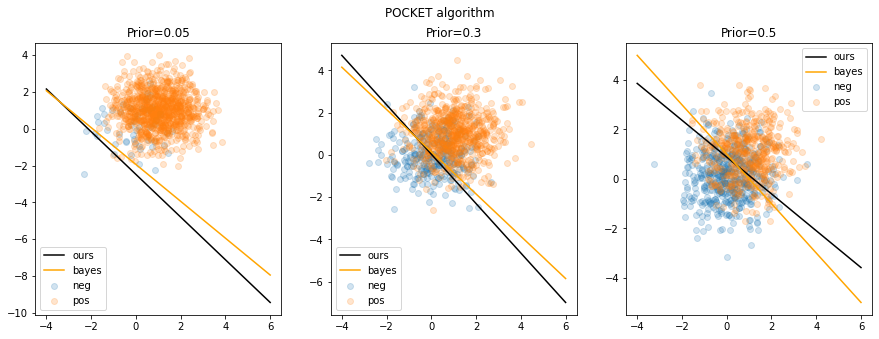

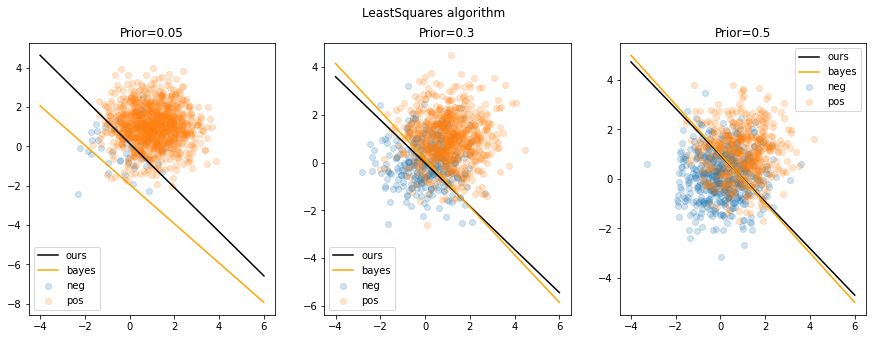

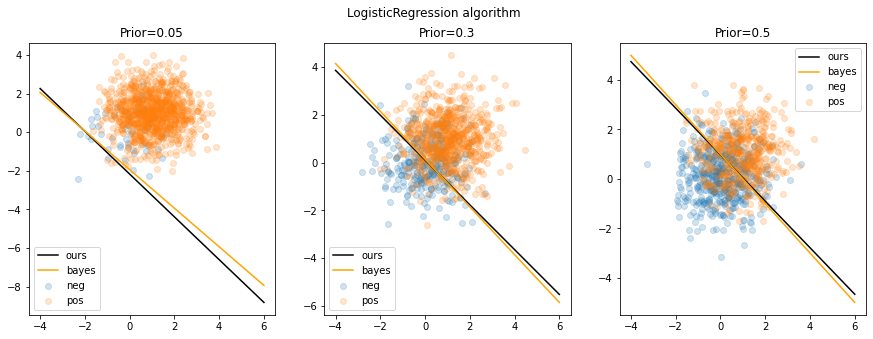

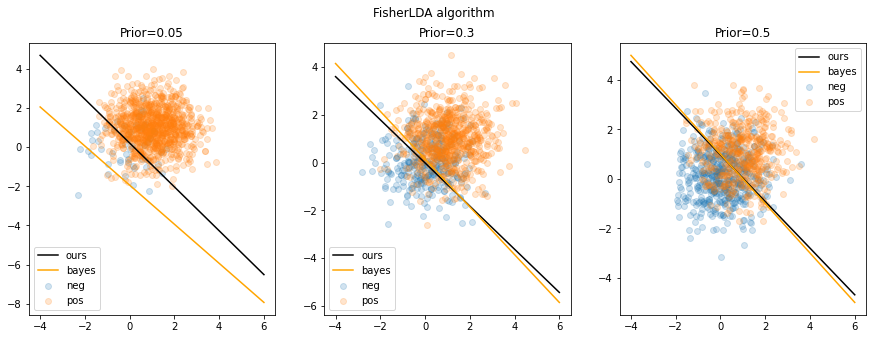

In [ ]:
# show bayes boundary
np.random.seed(0)
data = {
    prior: generate_data(2, 2000, 1000, prior, np.zeros((2,)), np.ones((2,)), np.eye(2), np.eye(2))
    for prior in priors
}

bb = pd.DataFrame({})
for p0 in [.05, .3, .5]:
    w = np.array(bayes_q1a(p0))
    X_train, y_train, X_test, y_test = data[p0]
    y_hat = (X_test.dot(w[:-1]) + w[-1]) > 0
    
    bb = bb.append({'prior': p0,
                    'bayes_acc'  : (y_test == y_hat).mean(),
                    'bayes_f1'   : f1_score(y_test, y_hat),
                    'weights': w.round(2)}, ignore_index=True)

print("Bayes Decision Boundary")
display(bb.set_index('prior'))
print('\n')

stats_and_plot(2, data, bb, plot=True)

#### Transformation degree = 2
- We do not see much change in test accuracy/f1_score since the bayes decision boundary is linear.
- Adding complexity to the model has increased train acc/f1 and is an example of small amount of overfitting.

In [ ]:
print("On adding quadratic features...")
np.random.seed(0)
data = {
    prior: generate_data(2, 2000, 1000, prior, np.zeros((2,)), np.ones((2,)), np.eye(2), np.eye(2), transform=True, degree=2)
    for prior in priors
}
stats_and_plot(2, data, bb=None, plot=False)

On adding quadratic features...
POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.950,0.950,0.953,0.974,0.974,0.976,"[0.58, 0.54, 0.28, 0.49, 0.02, 0.5, 0.2]","[3.0, 2.44, 5.06, -0.44, -0.7, 6.0, 3.0]"
0.30,0.794,0.785,0.766,0.860,0.854,0.829,"[-0.15, 0.6, 0.56, 0.14, 0.33, 0.23, 0.04]","[-1.0, 6.27, 5.82, -1.36, 2.71, -0.05, -1.0]"
0.50,0.776,0.721,0.669,0.776,0.722,0.718,"[-0.6, 0.58, 0.6, 0.05, 0.54, 0.18, -0.04]","[-1.0, 0.39, 4.05, 1.53, -0.32, 1.74, -1.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.918,0.929,0.951,0.957,0.962,0.975,"[0.43, 0.1, 0.09, -0.02, -0.03, -0.02, 0.43]","[0.0, 0.1, 0.09, -0.02, -0.03, -0.02, 0.86]"
0.30,0.800,0.797,0.792,0.865,0.864,0.863,"[0.26, 0.19, 0.19, -0.02, -0.03, -0.01, 0.26]","[0.0, 0.19, 0.19, -0.02, -0.03, -0.01, 0.52]"
0.50,0.782,0.722,0.722,0.778,0.720,0.725,"[0.17, 0.17, 0.18, -0.01, 0.01, -0.01, 0.17]","[0.0, 0.17, 0.18, -0.01, 0.01, -0.01, 0.34]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.950,0.952,0.952,0.974,0.975,0.975,"[1.05, 1.05, 0.96, -0.09, -0.03, -0.08, 1.05]","[-0.0, 1.03, 0.94, -0.09, -0.02, -0.07, 2.1]"
0.30,0.795,0.791,0.791,0.861,0.859,0.859,"[-0.05, 1.0, 0.99, -0.05, 0.05, 0.04, -0.05]","[0.0, 0.99, 0.98, -0.05, 0.06, 0.04, -0.1]"
0.50,0.779,0.718,0.718,0.779,0.719,0.719,"[-0.49, 1.0, 1.15, -0.01, 0.11, -0.1, -0.49]","[-0.0, 0.99, 1.14, -0.01, 0.12, -0.09, -0.98]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.922,0.935,0.951,0.959,0.966,0.974,"[0.0, 2.42, 2.24, -0.43, -0.68, -0.39, 0.72]","[0.0, 2.43, 2.25, -0.43, -0.68, -0.39, 2.04]"
0.30,0.800,0.798,0.794,0.865,0.865,0.863,"[0.0, 1.28, 1.3, -0.14, -0.19, -0.1, -0.03]","[0.0, 1.28, 1.3, -0.14, -0.19, -0.1, 0.04]"
0.50,0.782,0.722,0.722,0.779,0.720,0.725,"[0.0, 1.05, 1.13, -0.05, 0.07, -0.07, -1.05]","[0.0, 1.05, 1.13, -0.05, 0.07, -0.07, -0.97]"


### Same mean different covariance

#### Without feature transform

POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.960,0.961,0.947,0.979,0.980,0.973,"[0.2, -0.21, 0.3]","[0.39, 0.01, 1.0]"
0.30,0.766,0.750,0.712,0.856,0.846,0.829,"[0.19, -0.19, 0.2]","[0.35, -0.46, 1.0]"
0.50,0.642,0.610,0.505,0.727,0.707,0.024,"[-0.12, 0.12, 0.08]","[0.59, 0.36, -2.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.626,0.629,0.950,0.762,0.765,0.974,"[0.02, -0.03, 0.95]","[0.02, -0.03, 0.95]"
0.30,0.520,0.524,0.700,0.607,0.608,0.824,"[-0.0, 0.01, 0.7]","[-0.0, 0.01, 0.7]"
0.50,0.532,0.477,0.473,0.539,0.481,0.470,"[-0.01, 0.01, 0.5]","[-0.01, 0.01, 0.5]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.950,0.950,0.950,0.974,0.974,0.974,"[0.47, -0.5, 2.98]","[0.44, -0.47, 2.97]"
0.30,0.700,0.700,0.700,0.824,0.824,0.824,"[-0.02, 0.06, 0.85]","[-0.02, 0.06, 0.85]"
0.50,0.524,0.473,0.474,0.525,0.470,0.472,"[-0.06, 0.04, 0.0]","[-0.06, 0.04, 0.0]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.687,0.686,0.950,0.809,0.808,0.974,"[0.51, -0.53, 0.11]","[0.51, -0.53, 2.98]"
0.30,0.520,0.527,0.700,0.611,0.612,0.824,"[-0.02, 0.06, 0.0]","[-0.02, 0.06, 0.85]"
0.50,0.535,0.481,0.473,0.545,0.489,0.470,"[-0.06, 0.04, 0.0]","[-0.06, 0.04, 0.0]"


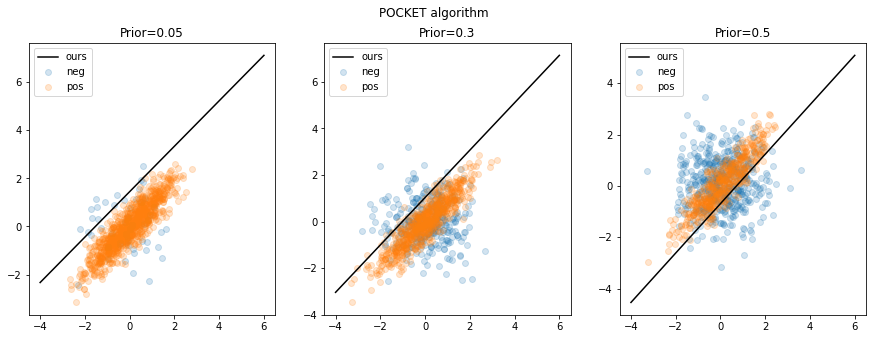

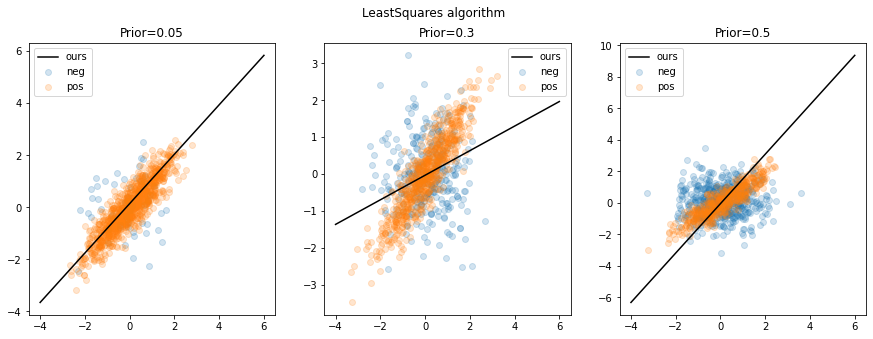

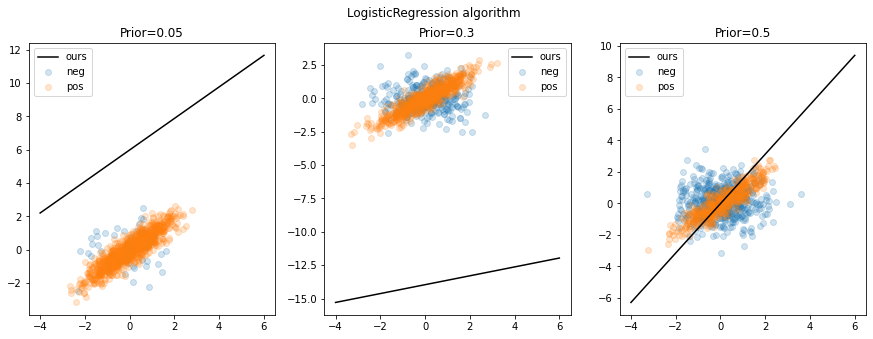

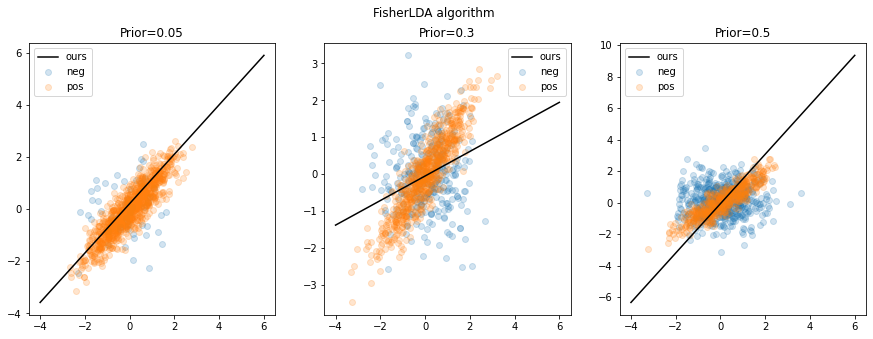

In [ ]:
dims = 2
np.random.seed(0)
data = {
    prior: generate_data(dims, 2000, 1000, prior, mu0 = np.zeros((dims,)),
            mu1=np.zeros((dims,)), covmat0=np.eye(2), covmat1=np.array([[1, .9], [.9, 1]]))
    for prior in priors
}
stats_and_plot(dims, data, bb=None, plot=True)

#### Transformation degree = 2


In [ ]:
print("On adding quadratic features...")
# show bayes boundary
priors = [.05, .3, .5]
dims=2
np.random.seed(0)
data = {
    prior: generate_data(dims, 2000, 1000, prior, mu0 = np.zeros((dims,)),
            mu1=np.zeros((dims,)), covmat0=np.eye(2), covmat1=np.array([[1, .9], [.9, 1]]), transform=True, degree=2)
    for prior in priors
}

bb = pd.DataFrame({})
for p0 in [.05, .3, .5]:
    w = bayes_q1c(p0, np.eye(2),
                  np.array([[1, .9], [.9, 1]])
        ) # b x1 x2 x1**2 x1x2 x2**2
    w = np.array(w)
    X_train, y_train, X_test, y_test = data[p0]
    y_hat = X_test.dot(w) > 0
    
    bb = bb.append({'prior': p0,
                    'bayes_acc'  : (y_test == y_hat).mean(),
                    'bayes_f1'   : f1_score(y_test, y_hat),
                    'weights': w.round(2)}, ignore_index=True)

print("Bayes Decision Boundary")
display(bb.set_index('prior'))
print('\n')

dims = 2
stats_and_plot(dims, data, bb=None, plot=False)

On adding quadratic features...
Bayes Decision Boundary


,bayes_acc,bayes_f1,weights
prior,,,
0.05,0.969,0.983929,"[3.77, 0.0, 0.0, -2.13, 4.74, -2.13]"
0.30,0.815,0.878847,"[1.68, 0.0, 0.0, -2.13, 4.74, -2.13]"
0.50,0.735,0.768559,"[0.83, 0.0, 0.0, -2.13, 4.74, -2.13]"




POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.967,0.967,0.963,0.983,0.983,0.981,"[0.38, 0.12, -0.01, -0.18, 0.6, -0.13, 0.0]","[2.0, 2.65, 2.13, 1.07, 14.16, -0.99, 2.0]"
0.30,0.834,0.807,0.793,0.888,0.871,0.861,"[0.75, 0.14, -0.13, -0.42, 1.16, -0.57, -0.46]","[1.0, 2.78, 0.4, -2.36, 16.92, -5.94, 1.0]"
0.50,0.771,0.729,0.624,0.803,0.770,0.493,"[0.33, -0.13, 0.16, -0.61, 1.42, -0.6, -0.03]","[0.0, -0.07, -1.44, -7.32, 15.59, -7.06, 0.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.970,0.969,0.962,0.984,0.984,0.980,"[0.49, 0.0, -0.0, -0.14, 0.29, -0.14, 0.49]","[0.0, 0.0, -0.0, -0.14, 0.29, -0.14, 0.99]"
0.30,0.834,0.811,0.778,0.889,0.874,0.863,"[-763326545046.74, 0.03, -0.02, -0.1, 0.26, -0.11, 763326545047.48]","[0.0, 0.03, -0.02, -0.1, 0.26, -0.11, 0.74]"
0.50,0.769,0.726,0.722,0.801,0.768,0.774,"[2880729406525.78, -0.01, 0.01, -0.06, 0.22, -0.07, -2880729406525.23]","[0.0, -0.01, 0.01, -0.06, 0.22, -0.07, 0.54]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.968,0.969,0.969,0.983,0.984,0.984,"[2.01, -0.12, 0.05, -2.43, 5.06, -2.4, 2.01]","[-0.0, -0.13, 0.06, -1.93, 4.07, -1.91, 3.77]"
0.30,0.837,0.818,0.813,0.892,0.880,0.878,"[0.84, 0.17, -0.16, -2.26, 5.12, -2.3, 0.84]","[-0.0, 0.15, -0.14, -2.0, 4.57, -2.03, 1.59]"
0.50,0.774,0.737,0.734,0.798,0.768,0.768,"[0.44, -0.11, 0.1, -2.35, 5.41, -2.44, 0.44]","[-0.0, -0.11, 0.1, -2.06, 4.76, -2.12, 0.8]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.970,0.969,0.971,0.984,0.984,0.985,"[0.0, 0.04, -0.07, -4.01, 8.36, -4.18, 6.4]","[0.0, 0.04, -0.07, -4.04, 8.43, -4.21, 7.7]"
0.30,0.834,0.813,0.783,0.889,0.876,0.866,"[0.0, 0.21, -0.13, -0.59, 1.6, -0.67, 0.37]","[0.0, 0.21, -0.13, -0.59, 1.61, -0.67, 1.38]"
0.50,0.770,0.727,0.722,0.802,0.769,0.774,"[0.0, -0.03, 0.05, -0.33, 1.13, -0.37, 0.13]","[0.0, -0.03, 0.05, -0.33, 1.13, -0.37, 0.22]"


### Different means different covariances

#### Without feature transform

POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.999,0.997,0.999,0.999,0.999,0.999,"[0.42, -0.61, 0.6]","[5.27, -11.57, 16.0]"
0.30,0.998,0.997,0.996,0.999,0.998,0.997,"[0.07, -0.97, 2.01]","[0.5, -10.82, 17.0]"
0.50,0.996,0.996,0.994,0.996,0.996,0.994,"[0.17, -1.01, 1.15]","[0.91, -13.95, 15.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,1.000,0.998,0.994,1.000,0.999,0.997,"[-0.0, -0.08, 0.83]","[-0.0, -0.08, 0.83]"
0.30,0.999,0.997,0.997,0.999,0.998,0.998,"[0.0, -0.11, 0.73]","[0.0, -0.11, 0.73]"
0.50,0.997,0.997,0.997,0.997,0.997,0.997,"[0.0, -0.11, 0.72]","[0.0, -0.11, 0.72]"




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.999,0.999,0.999,0.999,0.999,1.000,"[1.34, -3.06, 4.09]","[-0.18, -2.53, 7.76]"
0.30,0.997,0.997,0.997,0.998,0.998,0.998,"[0.64, -2.75, 4.25]","[-0.07, -2.75, 6.53]"
0.50,0.996,0.997,0.997,0.995,0.997,0.997,"[0.79, -3.07, 3.62]","[0.18, -2.92, 5.16]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,1.000,0.998,0.999,1.000,0.999,1.000,"[-0.12, -4.17, 8.4]","[-0.12, -4.17, 11.61]"
0.30,0.999,0.997,0.997,0.999,0.998,0.998,"[0.17, -3.98, 9.23]","[0.17, -3.98, 8.3]"
0.50,0.997,0.996,0.997,0.997,0.996,0.997,"[0.02, -3.88, 6.61]","[0.02, -3.88, 7.63]"


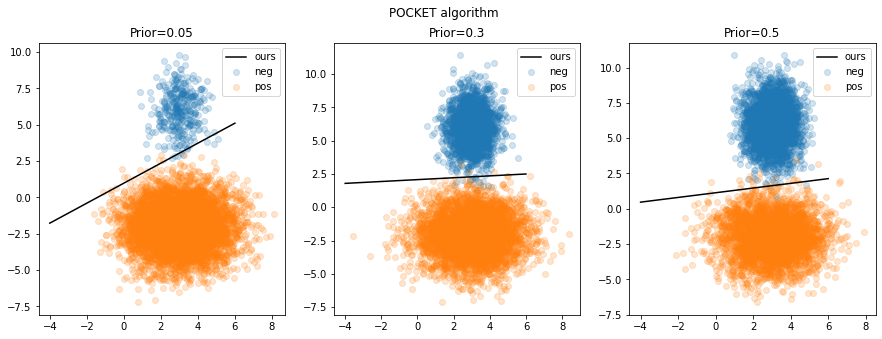

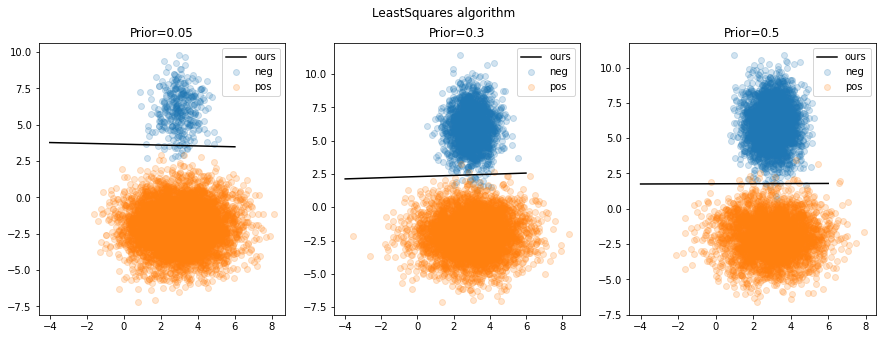

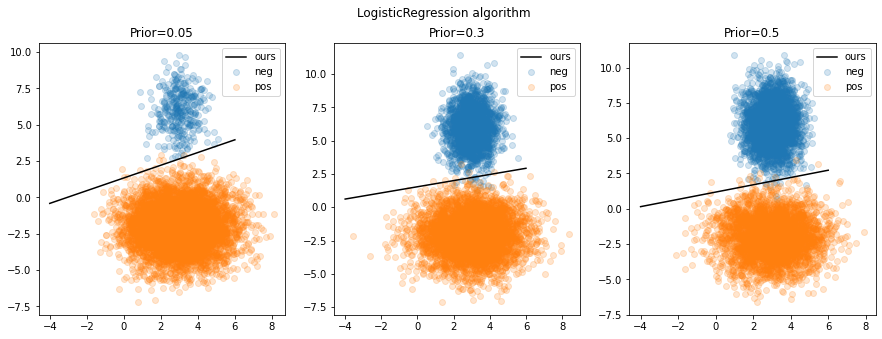

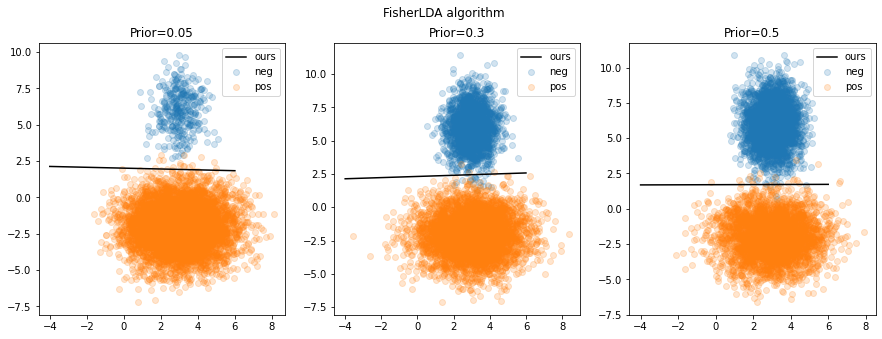

In [ ]:
dims = 2
priors = [.05, .3, .5]
np.random.seed(0)
data = {
    prior: generate_data(dims, 2000, 7000, prior, mu0 = np.array([3, 6]),
            mu1=np.array([3, -2]), covmat0=np.array([[.5, 0],[0, 2]]), covmat1=np.array([[2, 0], [0, 2]]))
    for prior in priors
}

stats_and_plot(dims, data, bb=None, plot=True)

#### Transformation degree = 2

In [ ]:
def bayes_q1d(p0):
    # b x1 x2 x1**2 x1x2 x2**2
    b = 25.25 + np.log((1-p0)/(2*p0))
    return [b, 4.5, -16, -.75, 0, 0]

print("On adding quadratic features...")
# show bayes boundary
priors = [.05, .3, .5]
dims=2
np.random.seed(0)
data = {
    prior: generate_data(dims, 2000, 7000, prior, mu0 = np.array([3, 6]),
            mu1=np.array([3, -2]), covmat0=np.array([[.5, 0],[0, 2]]), covmat1=np.array([[2, 0], [0, 2]]), transform=True, degree=2)
    for prior in priors
}


bb = pd.DataFrame({})
for p0 in priors:
    w = bayes_q1d(p0) # b x1 x2 x1**2 x1x2 x2**2
    w = np.array(w)
    X_train, y_train, X_test, y_test = data[p0]
    y_hat = X_test.dot(w) > 0
    
    bb = bb.append({'prior': p0,
                    'bayes_acc'  : (y_test == y_hat).mean(),
                    'bayes_f1'   : f1_score(y_test, y_hat),
                    'weights': w.round(2)}, ignore_index=True)

print("Bayes Decision Boundary")
display(bb.set_index('prior'))
print('\n')

dims = 2
stats_and_plot(dims, data, bb=None, plot=False)

On adding quadratic features...
Bayes Decision Boundary


,bayes_acc,bayes_f1,weights
prior,,,
0.05,0.998143,0.999022,"[27.5, 4.5, -16.0, -0.75, 0.0, 0.0]"
0.30,0.996857,0.997755,"[25.4, 4.5, -16.0, -0.75, 0.0, 0.0]"
0.50,0.996571,0.996568,"[24.56, 4.5, -16.0, -0.75, 0.0, 0.0]"




POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.998,0.997,0.998,0.999,0.998,0.999,"[3.21, 2.02, -4.39, 5.8, -7.01, 1.57, 2.6]","[54.0, 32.04, -41.3, 26.34, -59.13, 6.21, 54.0]"
0.30,0.998,0.997,0.997,0.999,0.998,0.998,"[11.26, 8.84, -9.71, 0.88, -5.22, 0.1, 11.59]","[94.0, 67.46, -98.18, 14.09, -45.3, 4.2, 94.0]"
0.50,0.996,0.997,0.995,0.996,0.997,0.995,"[7.14, 1.88, -9.05, 3.04, -6.01, -0.07, 6.0]","[79.0, 27.25, -102.85, 45.91, -67.21, 8.2, 79.0]"




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,1.000,0.997,0.996,1.000,0.998,0.998,"[0.48, -0.01, -0.06, 0.0, -0.0, -0.01, 0.48]","[0.0, -0.01, -0.06, 0.0, -0.0, -0.01, 0.95]"
0.30,0.998,0.997,0.995,0.999,0.998,0.996,"[0.43, -0.03, -0.09, 0.01, 0.0, -0.01, 0.43]","[0.0, -0.03, -0.09, 0.01, 0.0, -0.01, 0.86]"
0.50,0.997,0.998,0.998,0.997,0.998,0.998,"[0.4, -0.05, -0.11, 0.01, 0.0, -0.0, 0.4]","[0.0, -0.05, -0.11, 0.01, 0.0, -0.0, 0.79]"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,0.999,0.999,0.999,0.999,0.999,0.999,"[2.4, 1.18, -1.18, 1.82, -3.56, 0.69, 2.4]","[-0.0, -0.16, -0.4, 0.07, -0.78, -0.26, 9.69]"
0.30,0.999,0.996,0.997,0.999,0.997,0.998,"[2.16, 1.05, -1.28, -0.03, -0.44, -0.2, 2.16]","[-0.0, -0.34, -1.26, 0.14, -0.33, -0.26, 6.39]"
0.50,0.996,0.997,0.997,0.996,0.997,0.997,"[2.31, 0.68, -1.88, 0.2, -0.98, 0.16, 2.31]","[0.0, -0.36, -1.12, 0.29, -0.65, -0.16, 4.89]"




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1,weights,sk_weights
prior,,,,,,,,
0.05,1.000,0.998,0.997,1.000,0.999,0.998,"[0.0, -1.34, -8.92, 0.15, -0.16, -1.69, 27.14]","[0.0, -1.34, -8.98, 0.15, -0.16, -1.71, 61.86]"
0.30,0.998,0.997,0.995,0.999,0.998,0.996,"[0.0, -1.42, -3.94, 0.27, 0.04, -0.24, 11.29]","[0.0, -1.42, -3.94, 0.27, 0.04, -0.24, 15.05]"
0.50,0.997,0.997,0.998,0.997,0.997,0.998,"[0.0, -1.74, -3.98, 0.3, 0.06, -0.03, 8.8]","[0.0, -1.74, -3.98, 0.3, 0.06, -0.03, 10.24]"


 ## Question 2

In [ ]:
def german_frame(test_size=.2, transform=False, to_normalize=False, degree=2, retframe=False):
    with open('german.data-numeric', 'r') as file:
        lines = file.read().strip().split('\n')
        lines = list(map(str.split, lines))
        german = pd.DataFrame(data=lines).astype(int)
        german.columns = [f'c{i}' for i in range(24)] + ['target']
        german.target -= 1 # to make target within 0 and 1
    
    if retframe:
        return german
    
    input_features = list(german)
    input_features.remove("target")

    X, y = np.array(german[input_features]), np.array(german['target'])
    
    if transform:
        poly = PolynomialFeatures(degree)
        X = np.concatenate((X, poly.fit_transform(X[:, :10])), axis=-1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    if normalize:
        X_train, y_train, X_test, y_test = normalize(X_train, y_train, X_test, y_test)

    return X_train, y_train, X_test, y_test

In [ ]:
german = german_frame(retframe=True)
german.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,target
0,1,6,4,12,5,5,3,4,1,67,3,2,1,2,1,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,3,1,1,1,1,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,3,1,2,1,1,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,3,1,2,1,1,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,3,2,2,1,1,1,0,1,0,0,0,0,0,1,1


### EDA

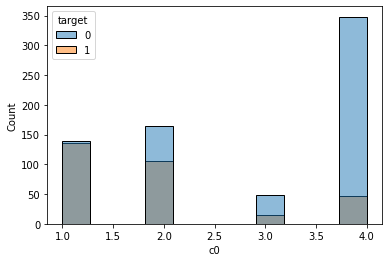

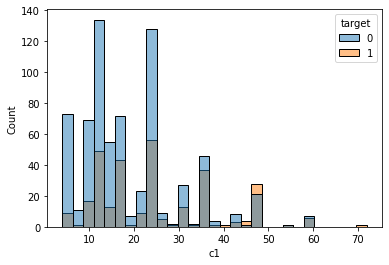

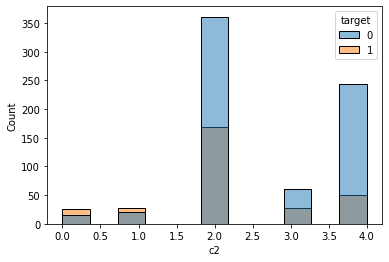

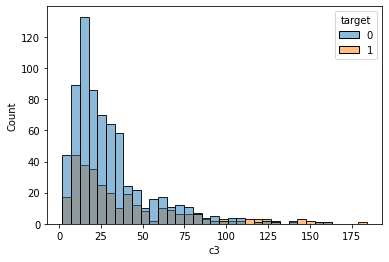

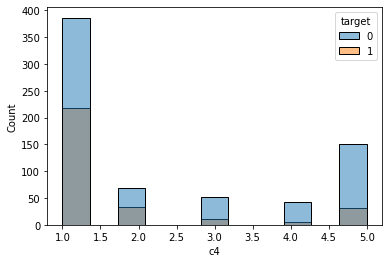

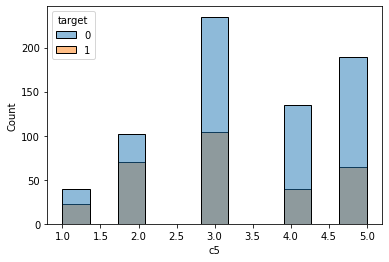

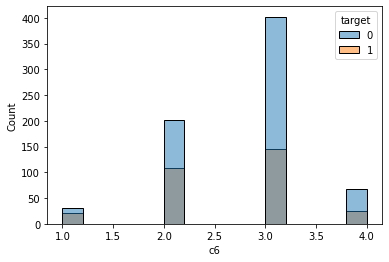

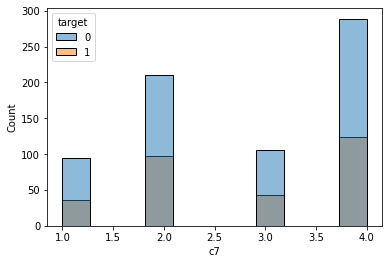

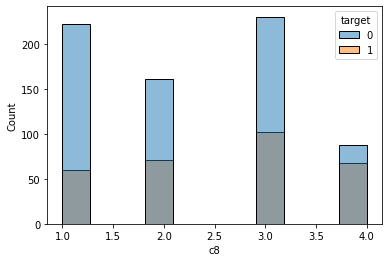

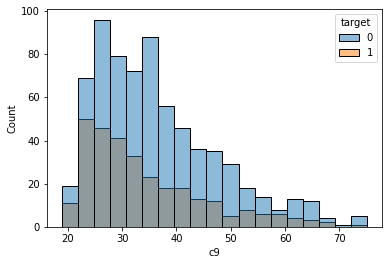

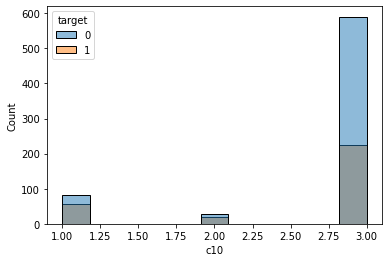

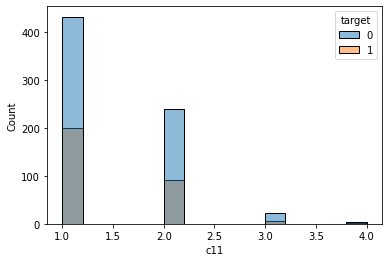

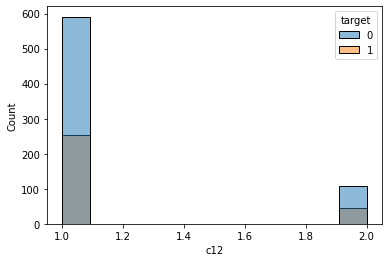

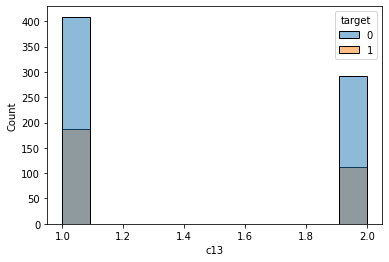

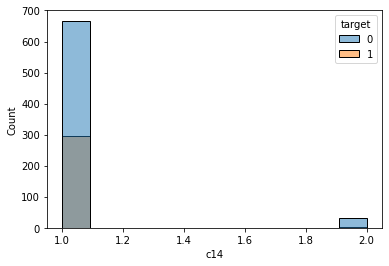

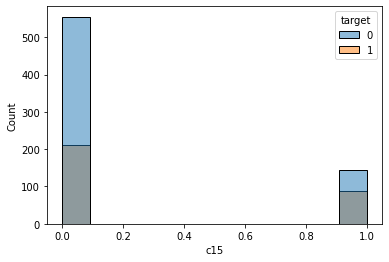

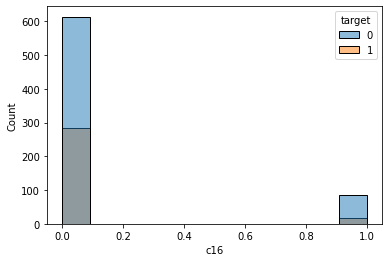

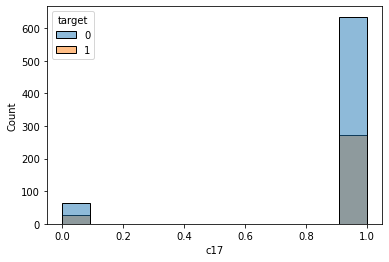

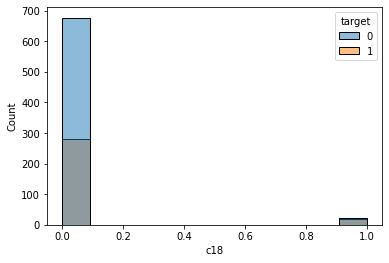

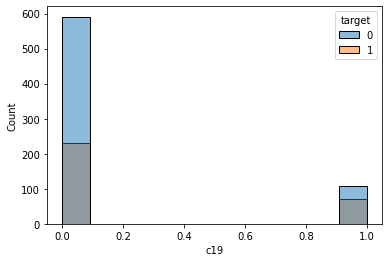

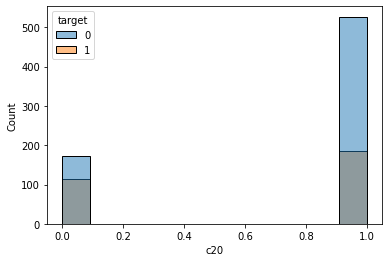

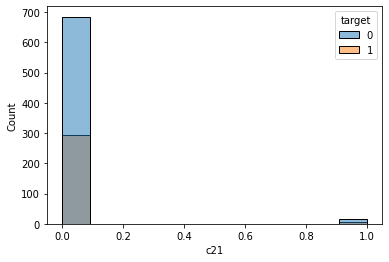

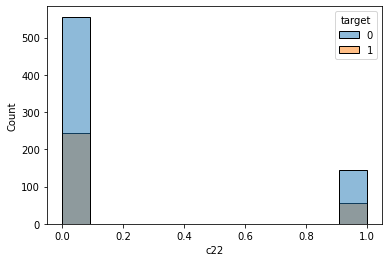

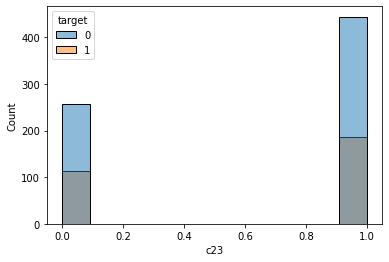

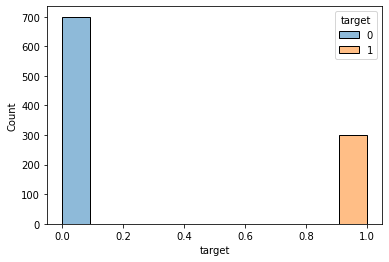

In [ ]:
for col in german:
    sns.histplot(x=col, data=german, hue='target')
    plt.show()

In [ ]:
X_train, y_train, X_test, y_test = german_frame()

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

print("Positive classes", y_train.mean() * 100, "%")

(800, 24) (800,)
(200, 24) (200,)
Positive classes 30.0 %


### Get metrics for German.data

### Without feature transformation

In [ ]:
def show_stats(data):
    for model in [Pocket, LeastSquares, LogReg, FisherLDA]:
        frame = pd.DataFrame({
            'test_size': [], 'train_acc':[], 'acc': [], 'sk_acc': [], 'train_f1':[], 'f1': [], 'sk_f1': []
        })
        for t, (X_train, y_train, X_test, y_test) in data.items():
            W, *b = model.fit(X_train, y_train)
            tr_preds, tr_acc = model.predict(X_train, y_train, W, *b)
            preds, acc = model.predict(X_test, y_test, W, *b)
            preds_sk, accuracy_sk, skW, skB = model.sk_predict(X_train, y_train, X_test, y_test)
            
            frame = frame.append({
                'test_size' : t,
                'train_acc': tr_acc,
                'acc'   : acc,
                'sk_acc': accuracy_sk,
                'train_f1': f1_score(y_train, tr_preds),
                'f1'    : f1_score(y_test, preds),
                'sk_f1' : f1_score(y_test, preds_sk),
            }, ignore_index=True)
        frame = frame.round(3).set_index('test_size')
        print(f"{model.name} algorithm")
        display(frame)
        print('\n')


print("Without transforming")
test_sizes = [.2, .3]
np.random.seed(0)
data = {
    t: german_frame(t, transform=False, to_normalize=True)
    for t in test_sizes
}
LogReg.lr = 1e-1
show_stats(data)

Without transforming
POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.772,0.740,0.690,0.500,0.447,0.597
0.3,0.776,0.687,0.687,0.529,0.338,0.113




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.795,0.765,0.765,0.627,0.569,0.535
0.3,0.796,0.733,0.733,0.619,0.500,0.500




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.780,0.760,0.77,0.562,0.529,0.540
0.3,0.786,0.717,0.73,0.595,0.459,0.484




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.786,0.755,0.770,0.647,0.574,0.566
0.3,0.793,0.700,0.723,0.660,0.536,0.497


### Transform degree 4

In [ ]:
print("After quadratic transformation")
test_sizes = [.2, .3]
np.random.seed(0)
data = {
    t: german_frame(t, transform=True, to_normalize=True, degree=4)
    for t in test_sizes
}
LogReg.lr = 1e-3
show_stats(data)

After quadratic transformation
POCKET algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.781,0.770,0.57,0.615,0.596,0.552
0.3,0.793,0.707,0.75,0.625,0.494,0.586




LeastSquares algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,1.0,0.460,0.515,1.0,0.341,0.340
0.3,1.0,0.503,0.553,1.0,0.433,0.407




LogisticRegression algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.742,0.750,0.775,0.376,0.444,0.587
0.3,0.760,0.717,0.737,0.458,0.351,0.533




FisherLDA algorithm


,train_acc,acc,sk_acc,train_f1,f1,sk_f1
test_size,,,,,,
0.2,0.3,0.350,0.625,0.462,0.444,0.490
0.3,0.3,0.437,0.557,0.462,0.470,0.453


### Non Linear Classifier

In [ ]:
test_sizes = [.2, .3]
np.random.seed(0)

data = {
    t: german_frame(t, transform=True, to_normalize=True, degree=4)
    for t in test_sizes
}


params = {
    'learning_rate': 7e-2,
    'n_estimators': 75,
    'subsample': 0.9,
    'max_depth': 6,
    'colsample_bytree': .6,
}

model = xgb.XGBClassifier(objective='reg:logistic', **params)

for t, (X_train, y_train, X_test, y_test) in data.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'Test size: {t}')
    trpreds = model.predict(X_train)
    print(f'  F1  score: {f1_score(y_train, trpreds):.3f}(train), {f1_score(y_test, preds):.3f}(test)')
    print(f'  Acc score: {(y_train == trpreds).mean():.3f}(train), {(y_test == preds).mean():.3f}(test)')

Test size: 0.2
  F1  score: 1.000(train), 0.544(test)
  Acc score: 1.000(train), 0.765(test)
Test size: 0.3
  F1  score: 1.000(train), 0.522(test)
  Acc score: 1.000(train), 0.743(test)


## Question 3

#### Without feature transformation

In [ ]:
def drive_frame_ensemble(test_size=.2):
    df = pd.read_csv('train.csv').drop('id', axis=1).sample(frac=.3).reset_index(drop=True)

    for col in list(df):
        if col[-3:] == 'cat':
            dummies = pd.get_dummies(df[col].apply(lambda x: f'{col}_{x}'))
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    np.random.seed(0)
    mask = np.random.rand(len(df)) <= test_size
    train, test = df[~mask].reset_index(drop=True), df[mask].reset_index(drop=True)
    
    pos_train = train[train.target==1]
    neg_train = train[train.target==0].reset_index(drop=True)

    
    """
        If I break 97 rows into 97//3 groups I will get each group to match with postive examples.
        I will choose 5 of them randomly as follows
    """
    
    mask = np.random.randint(26, size=len(neg_train))
    train_samples = [
        pd.concat((neg_train[mask==i], pos_train), axis=0).reset_index(drop=True)
        for i in range(5)
    ]
    
    return train_samples, test

train_samples, test = drive_frame_ensemble()
for train in train_samples:
    print(train.shape)
    print(train.target.mean())
print(test.shape)
print(test.target.mean())

(10479, 228)
0.4893596717244012
(10401, 228)
0.4930295163926546
(10371, 228)
0.4944556937614502
(10366, 228)
0.49469419255257574
(10500, 228)
0.48838095238095236
(35711, 228)
0.03755145473383551


In [ ]:
def drive_frame(test_size=.2):
    df = pd.read_csv('train.csv').drop('id', axis=1).sample(frac=.3).reset_index(drop=True)

    for col in list(df):
        if col[-3:] == 'cat':
            dummies = pd.get_dummies(df[col].apply(lambda x: f'{col}_{x}'))
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    np.random.seed(0)
    mask = np.random.rand(len(df)) <= test_size
    train, test = df[~mask].reset_index(drop=True), df[mask].reset_index(drop=True)
    
    input_features = [col for col in df if col != 'target']

    # normalization using train data estimates
    mitr, matr = train[input_features].min(), train[input_features].max()
    diff = (matr - matr + 1e-8)
    train[input_features] = (train[input_features] - mitr) / diff
    test[input_features]  = (test[input_features]  - mitr) / diff

    # undersampling majority class
    # will select negative examples with prob 5% and positive example with prob 1
    mask = (np.random.rand(len(train)) <= 1/20) | np.array(train.target == 1) 
    train = train[mask].reset_index(drop=True)
        
    X_train, X_test, y_train, y_test = map(np.array, (train[input_features], test[input_features], train.target, test.target))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = drive_frame()

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

print("Percentage of positive classes", y_train.mean() * 100)

(12213, 227) (12213,)
(35711, 227) (35711,)
Percentage of positive classes 43.27356095963318


In [ ]:
test_sizes = [.2, .3]
data = {
    t: drive_frame(t)
    for t in test_sizes
}

In [ ]:
LogReg.lr = 1e-5
for model in [Pocket, LeastSquares, LogReg, FisherLDA]:
    frame = pd.DataFrame({
        'test_size': [], 'acc': [], 'f1': [],
    })
    for t in test_sizes:
        X_train, y_train, X_test, y_test = data[t]
        W, *b = model.fit(X_train, y_train)
        preds, acc = model.predict(X_test, y_test, W, *b)
        frame = frame.append({
            'test_size' : t,
            'acc'   : acc,
            'f1'    : f1_score(y_test, preds),
        }, ignore_index=True)
        
    frame = frame.round(3).set_index('test_size')
    print(f"{model.name} algorithm")
    display(frame)
    print('\n')

POCKET algorithm


,acc,f1
test_size,,
0.2,0.823,0.086
0.3,0.921,0.079




LeastSquares algorithm


,acc,f1
test_size,,
0.2,0.716,0.093
0.3,0.708,0.100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


LogisticRegression algorithm


,acc,f1
test_size,,
0.2,0.035,0.068
0.3,0.964,0.000




FisherLDA algorithm


,acc,f1
test_size,,
0.2,0.763,0.098
0.3,0.737,0.101


#### Non Linear Classifier

In [ ]:
test_sizes = [.2, .3]
np.random.seed(0)

params = {
    'learning_rate': 7e-2,
    'n_estimators': 100,
    'subsample': 0.9,
    'max_depth': 6,
    'colsample_bytree': .8,
}

for t in test_sizes:
    print(f'Test size: {t}')
    preds = []
    train_samples, test = drive_frame_ensemble(t)
    input_features = list(test)
    input_features.remove('target')

    X_test, y_test = np.array(test[input_features]), np.array(test.target)
    
    print("Training:")
    for i, train in enumerate(train_samples):
        model = xgb.XGBClassifier(objective='binary:logistic', **params)
        X_train, y_train = np.array(train[input_features]), np.array(train.target)
        model.fit(X_train, y_train)
        preds.append(model.predict(X_test).flatten())
        trpreds = model.predict(X_train).flatten() > .5
        print(f"  Fold{i}: Acc: {(y_train == trpreds).mean():.3f}, f1:{f1_score(y_train, trpreds):.3f}")


    preds = np.array(preds).mean(axis=0)
    threshs = np.linspace(.2, .8, num=100)
    i = np.argmax([
        f1_score(y_test, preds>=thresh)
        for thresh in threshs
    ])

    preds = (preds >= threshs[i])

    print('Testing:')
    print(f"  Acc: {(y_test == preds).mean():.3f}, f1:{f1_score(y_test, preds):.3f}")

Test size: 0.2
Training:
  Fold0: Acc: 0.781, f1:0.763
  Fold1: Acc: 0.789, f1:0.777
  Fold2: Acc: 0.774, f1:0.762
  Fold3: Acc: 0.775, f1:0.763
  Fold4: Acc: 0.777, f1:0.760
Testing:
  Acc: 0.703, f1:0.099
Test size: 0.3
Training:
  Fold0: Acc: 0.794, f1:0.786
  Fold1: Acc: 0.801, f1:0.795
  Fold2: Acc: 0.796, f1:0.794
  Fold3: Acc: 0.796, f1:0.790
  Fold4: Acc: 0.785, f1:0.778
Testing:
  Acc: 0.687, f1:0.101


In [ ]:
print(f"Notebook ran in {time.time() - nb_start} seconds")

Notebook ran in 235.3162066936493 seconds
